In [1]:
import os
import torch
import random
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from datasets import DatasetDict, Dataset
from transformers import AutoImageProcessor
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# Step 2: Load and Prepare the Dataset

Since you have a folder structure where each folder represents a class, we will use datasets from Hugging Face to load the dataset efficiently.

2.1 - Load Data and Split into Train/Validation Sets

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the paths to your training and testing datasets
train_data_dir = "C:/Users/Amir/Desktop/skin cancer paper/skin cancer isic/Skin Cancer ISIC/Skin cancer ISIC The International Skin Imaging Collaboration/train"  # Replace with the path to your training dataset
test_data_dir = "C:/Users/Amir/Desktop/skin cancer paper/skin cancer isic/Skin Cancer ISIC/Skin cancer ISIC The International Skin Imaging Collaboration/test"  # Replace with the path to your testing dataset

# Define transformations for the images
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),  # Resize images to 224x224 (required for ConvNext)
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load the training dataset
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(test_data_dir, transform=transform)

# Split the training set into train and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Check the number of classes
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the sizes of the datasets
print(f"Training subset size: {len(train_subset)}")
print(f"Validation subset size: {len(val_subset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Number of classes: 9
Training subset size: 1791
Validation subset size: 448
Testing dataset size: 118


In [4]:
num_classes

9

# Using class weights for class imbalance

In [10]:
import numpy as np

# Get the class labels from the training dataset
class_labels = [label for _, label in train_dataset]

# Compute class counts
class_counts = np.bincount(class_labels)

# Compute class weights
class_weights = 1. / class_counts

# Normalize the weights (optional but recommended)
class_weights = class_weights / class_weights.sum()

# Print class weights
print("Class counts:", class_counts)
print("Class weights:", class_weights)

Class counts: [114 376  95 438 357 462  77 181 139]
Class weights: [0.15974328 0.0484328  0.19169194 0.04157702 0.05101046 0.03941717
 0.23650304 0.10061179 0.13101248]


# Importing model from huggingface

In [6]:
from transformers import ConvNextForImageClassification

# Load the pre-trained ConvNext model
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224", num_labels=num_classes,   ignore_mismatched_sizes=True
)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_fi

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

# Training 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm  # Import tqdm



# Convert class weights to a tensor and move to the device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)



# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap train_loader with tqdm for a progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar description with current loss and accuracy
        train_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    # Wrap val_loader with tqdm for a progress bar
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits  # Adjust if your model doesn't output .logits
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update the progress bar description with current loss and accuracy
            val_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.52it/s, accuracy=70.2, loss=0.676]


Epoch [1/100], Train Loss: 0.6852, Train Accuracy: 70.18%


Epoch [1/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=67, loss=1.25]   


Epoch [1/100], Val Loss: 0.9226, Val Accuracy: 66.96%


Epoch [2/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=74.1, loss=0.346]


Epoch [2/100], Train Loss: 0.4996, Train Accuracy: 74.15%


Epoch [2/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=69.2, loss=1.15]


Epoch [2/100], Val Loss: 0.9178, Val Accuracy: 69.20%


Epoch [3/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=76.3, loss=0.481]


Epoch [3/100], Train Loss: 0.5218, Train Accuracy: 76.33%


Epoch [3/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s, accuracy=57.4, loss=1.83] 


Epoch [3/100], Val Loss: 1.0651, Val Accuracy: 57.37%


Epoch [4/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=80.5, loss=0.457]


Epoch [4/100], Train Loss: 0.3767, Train Accuracy: 80.46%


Epoch [4/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=67, loss=1.93]   


Epoch [4/100], Val Loss: 0.9779, Val Accuracy: 66.96%


Epoch [5/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=83, loss=0.237]  


Epoch [5/100], Train Loss: 0.3351, Train Accuracy: 83.03%


Epoch [5/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, accuracy=69.9, loss=2.24] 


Epoch [5/100], Val Loss: 0.9551, Val Accuracy: 69.87%


Epoch [6/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=81.6, loss=0.415]


Epoch [6/100], Train Loss: 0.3718, Train Accuracy: 81.63%


Epoch [6/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=63.2, loss=1.39] 


Epoch [6/100], Val Loss: 1.0623, Val Accuracy: 63.17%


Epoch [7/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=84.6, loss=0.233]


Epoch [7/100], Train Loss: 0.3149, Train Accuracy: 84.65%


Epoch [7/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=67.4, loss=2]    


Epoch [7/100], Val Loss: 1.0166, Val Accuracy: 67.41%


Epoch [8/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=83.4, loss=0.153]


Epoch [8/100], Train Loss: 0.3402, Train Accuracy: 83.36%


Epoch [8/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.44it/s, accuracy=66.1, loss=1.48]


Epoch [8/100], Val Loss: 1.1233, Val Accuracy: 66.07%


Epoch [9/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=81.6, loss=0.427]


Epoch [9/100], Train Loss: 0.3731, Train Accuracy: 81.57%


Epoch [9/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=66.3, loss=1.66] 


Epoch [9/100], Val Loss: 1.0765, Val Accuracy: 66.29%


Epoch [10/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=84.3, loss=0.268] 


Epoch [10/100], Train Loss: 0.2961, Train Accuracy: 84.25%


Epoch [10/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.33it/s, accuracy=66.5, loss=1.54] 


Epoch [10/100], Val Loss: 1.1271, Val Accuracy: 66.52%


Epoch [11/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=86.3, loss=0.248] 


Epoch [11/100], Train Loss: 0.3186, Train Accuracy: 86.26%


Epoch [11/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, accuracy=67.4, loss=1.22]


Epoch [11/100], Val Loss: 1.1110, Val Accuracy: 67.41%


Epoch [12/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=88.6, loss=0.274] 


Epoch [12/100], Train Loss: 0.2362, Train Accuracy: 88.55%


Epoch [12/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.33it/s, accuracy=68.3, loss=1.09]


Epoch [12/100], Val Loss: 1.0685, Val Accuracy: 68.30%


Epoch [13/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=86.5, loss=0.39]  


Epoch [13/100], Train Loss: 0.2678, Train Accuracy: 86.49%


Epoch [13/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s, accuracy=68.3, loss=2.02]


Epoch [13/100], Val Loss: 1.3400, Val Accuracy: 68.30%


Epoch [14/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=88, loss=0.256]   


Epoch [14/100], Train Loss: 0.2501, Train Accuracy: 88.00%


Epoch [14/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=65.2, loss=1.95]


Epoch [14/100], Val Loss: 1.3393, Val Accuracy: 65.18%


Epoch [15/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=88.4, loss=0.264] 


Epoch [15/100], Train Loss: 0.2220, Train Accuracy: 88.39%


Epoch [15/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=66.7, loss=2.02]


Epoch [15/100], Val Loss: 1.3530, Val Accuracy: 66.74%


Epoch [16/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=88.6, loss=0.0976]


Epoch [16/100], Train Loss: 0.2494, Train Accuracy: 88.55%


Epoch [16/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=67.6, loss=2.01]


Epoch [16/100], Val Loss: 1.2401, Val Accuracy: 67.63%


Epoch [17/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=87, loss=0.366]   


Epoch [17/100], Train Loss: 0.2828, Train Accuracy: 87.05%


Epoch [17/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, accuracy=61.4, loss=2.02]


Epoch [17/100], Val Loss: 1.5944, Val Accuracy: 61.38%


Epoch [18/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=87.3, loss=0.125] 


Epoch [18/100], Train Loss: 0.3162, Train Accuracy: 87.33%


Epoch [18/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, accuracy=64.1, loss=1.97]


Epoch [18/100], Val Loss: 1.1902, Val Accuracy: 64.06%


Epoch [19/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=88.4, loss=0.516] 


Epoch [19/100], Train Loss: 0.2465, Train Accuracy: 88.44%


Epoch [19/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=60.5, loss=2.18]


Epoch [19/100], Val Loss: 1.6028, Val Accuracy: 60.49%


Epoch [20/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=89.3, loss=0.175] 


Epoch [20/100], Train Loss: 0.2225, Train Accuracy: 89.28%


Epoch [20/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, accuracy=69, loss=1.59]   


Epoch [20/100], Val Loss: 1.3132, Val Accuracy: 68.97%


Epoch [21/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=90.2, loss=0.248] 


Epoch [21/100], Train Loss: 0.1868, Train Accuracy: 90.23%


Epoch [21/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=68.1, loss=1.09]


Epoch [21/100], Val Loss: 1.3654, Val Accuracy: 68.08%


Epoch [22/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.56it/s, accuracy=92.4, loss=0.162] 


Epoch [22/100], Train Loss: 0.1601, Train Accuracy: 92.35%


Epoch [22/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, accuracy=67, loss=2.17]  


Epoch [22/100], Val Loss: 1.6078, Val Accuracy: 66.96%


Epoch [23/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=89.9, loss=0.177] 


Epoch [23/100], Train Loss: 0.2001, Train Accuracy: 89.89%


Epoch [23/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=59.2, loss=1.39] 


Epoch [23/100], Val Loss: 1.3857, Val Accuracy: 59.15%


Epoch [24/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=90.7, loss=0.161] 


Epoch [24/100], Train Loss: 0.1867, Train Accuracy: 90.73%


Epoch [24/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, accuracy=69.6, loss=1.27]


Epoch [24/100], Val Loss: 1.2888, Val Accuracy: 69.64%


Epoch [25/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=91, loss=0.21]    


Epoch [25/100], Train Loss: 0.1991, Train Accuracy: 90.95%


Epoch [25/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s, accuracy=60.3, loss=1.92]


Epoch [25/100], Val Loss: 1.5664, Val Accuracy: 60.27%


Epoch [26/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=88.4, loss=0.182] 


Epoch [26/100], Train Loss: 0.2569, Train Accuracy: 88.44%


Epoch [26/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s, accuracy=65.6, loss=2.49]


Epoch [26/100], Val Loss: 1.7067, Val Accuracy: 65.62%


Epoch [27/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=90.1, loss=0.346] 


Epoch [27/100], Train Loss: 0.2187, Train Accuracy: 90.12%


Epoch [27/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=61.8, loss=2.03]


Epoch [27/100], Val Loss: 1.4172, Val Accuracy: 61.83%


Epoch [28/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=90.4, loss=0.149] 


Epoch [28/100], Train Loss: 0.1924, Train Accuracy: 90.40%


Epoch [28/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, accuracy=65.4, loss=1.05]


Epoch [28/100], Val Loss: 1.2966, Val Accuracy: 65.40%


Epoch [29/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=91.8, loss=0.135]  


Epoch [29/100], Train Loss: 0.1585, Train Accuracy: 91.79%


Epoch [29/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=67.6, loss=1.6] 


Epoch [29/100], Val Loss: 1.5768, Val Accuracy: 67.63%


Epoch [30/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.57it/s, accuracy=93.5, loss=0.139]  


Epoch [30/100], Train Loss: 0.1327, Train Accuracy: 93.47%


Epoch [30/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=69.2, loss=1.9] 


Epoch [30/100], Val Loss: 1.4803, Val Accuracy: 69.20%


Epoch [31/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.58it/s, accuracy=94.1, loss=0.104]  


Epoch [31/100], Train Loss: 0.1209, Train Accuracy: 94.08%


Epoch [31/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.41it/s, accuracy=67.9, loss=1.82]


Epoch [31/100], Val Loss: 1.4925, Val Accuracy: 67.86%


Epoch [32/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.58it/s, accuracy=93.7, loss=0.295]  


Epoch [32/100], Train Loss: 0.1239, Train Accuracy: 93.69%


Epoch [32/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.41it/s, accuracy=60.7, loss=1.87]


Epoch [32/100], Val Loss: 1.9172, Val Accuracy: 60.71%


Epoch [33/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.57it/s, accuracy=93.6, loss=0.0781]


Epoch [33/100], Train Loss: 0.1332, Train Accuracy: 93.58%


Epoch [33/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, accuracy=54.7, loss=2.21]


Epoch [33/100], Val Loss: 1.9643, Val Accuracy: 54.69%


Epoch [34/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=89.8, loss=0.455] 


Epoch [34/100], Train Loss: 0.2345, Train Accuracy: 89.78%


Epoch [34/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.40it/s, accuracy=66.5, loss=2.93]


Epoch [34/100], Val Loss: 1.6480, Val Accuracy: 66.52%


Epoch [35/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=91.6, loss=0.354] 


Epoch [35/100], Train Loss: 0.1680, Train Accuracy: 91.57%


Epoch [35/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s, accuracy=57.4, loss=3.49]


Epoch [35/100], Val Loss: 1.9235, Val Accuracy: 57.37%


Epoch [36/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=90.2, loss=0.215] 


Epoch [36/100], Train Loss: 0.2112, Train Accuracy: 90.23%


Epoch [36/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s, accuracy=62.7, loss=2.49]


Epoch [36/100], Val Loss: 1.8211, Val Accuracy: 62.72%


Epoch [37/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=92, loss=0.191]   


Epoch [37/100], Train Loss: 0.1722, Train Accuracy: 91.96%


Epoch [37/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, accuracy=60.3, loss=1.83]


Epoch [37/100], Val Loss: 1.7048, Val Accuracy: 60.27%


Epoch [38/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=91.1, loss=0.216] 


Epoch [38/100], Train Loss: 0.2002, Train Accuracy: 91.07%


Epoch [38/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=62.9, loss=2.64]


Epoch [38/100], Val Loss: 1.9244, Val Accuracy: 62.95%


Epoch [39/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=92.2, loss=0.324] 


Epoch [39/100], Train Loss: 0.1639, Train Accuracy: 92.18%


Epoch [39/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=62.5, loss=2.77]


Epoch [39/100], Val Loss: 1.9836, Val Accuracy: 62.50%


Epoch [40/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=91.3, loss=0.276] 


Epoch [40/100], Train Loss: 0.1910, Train Accuracy: 91.29%


Epoch [40/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=64.7, loss=2.15]


Epoch [40/100], Val Loss: 2.0245, Val Accuracy: 64.73%


Epoch [41/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=92.7, loss=0.301] 


Epoch [41/100], Train Loss: 0.1569, Train Accuracy: 92.69%


Epoch [41/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=69.4, loss=2.3] 


Epoch [41/100], Val Loss: 1.7280, Val Accuracy: 69.42%


Epoch [42/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=93, loss=0.114]   


Epoch [42/100], Train Loss: 0.1400, Train Accuracy: 93.02%


Epoch [42/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=68.5, loss=2.4] 


Epoch [42/100], Val Loss: 1.8476, Val Accuracy: 68.53%


Epoch [43/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=94.2, loss=0.236]  


Epoch [43/100], Train Loss: 0.1093, Train Accuracy: 94.25%


Epoch [43/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, accuracy=64.3, loss=2.33]


Epoch [43/100], Val Loss: 1.7077, Val Accuracy: 64.29%


Epoch [44/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=92.4, loss=0.159] 


Epoch [44/100], Train Loss: 0.1474, Train Accuracy: 92.41%


Epoch [44/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=65.4, loss=2.91]


Epoch [44/100], Val Loss: 2.0433, Val Accuracy: 65.40%


Epoch [45/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=91, loss=0.0684]  


Epoch [45/100], Train Loss: 0.1714, Train Accuracy: 90.95%


Epoch [45/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=67.9, loss=3.08]


Epoch [45/100], Val Loss: 2.1620, Val Accuracy: 67.86%


Epoch [46/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=91.3, loss=0.323] 


Epoch [46/100], Train Loss: 0.1793, Train Accuracy: 91.29%


Epoch [46/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, accuracy=65.2, loss=2.94]


Epoch [46/100], Val Loss: 1.8292, Val Accuracy: 65.18%


Epoch [47/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=92.1, loss=0.0632]


Epoch [47/100], Train Loss: 0.1430, Train Accuracy: 92.13%


Epoch [47/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=67.4, loss=2.49]


Epoch [47/100], Val Loss: 1.7730, Val Accuracy: 67.41%


Epoch [48/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=93.2, loss=0.0515]


Epoch [48/100], Train Loss: 0.1380, Train Accuracy: 93.24%


Epoch [48/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, accuracy=65.4, loss=2.37]


Epoch [48/100], Val Loss: 1.8053, Val Accuracy: 65.40%


Epoch [49/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=94.4, loss=0.242] 


Epoch [49/100], Train Loss: 0.1054, Train Accuracy: 94.36%


Epoch [49/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=68.3, loss=3.42]


Epoch [49/100], Val Loss: 2.3590, Val Accuracy: 68.30%


Epoch [50/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=93.7, loss=0.103] 


Epoch [50/100], Train Loss: 0.1448, Train Accuracy: 93.69%


Epoch [50/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, accuracy=63.2, loss=3.39]


Epoch [50/100], Val Loss: 2.0551, Val Accuracy: 63.17%


Epoch [51/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=93.9, loss=0.0686] 


Epoch [51/100], Train Loss: 0.1175, Train Accuracy: 93.91%


Epoch [51/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.40it/s, accuracy=66.3, loss=2.9] 


Epoch [51/100], Val Loss: 1.8195, Val Accuracy: 66.29%


Epoch [52/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.57it/s, accuracy=93.7, loss=0.0983]


Epoch [52/100], Train Loss: 0.1165, Train Accuracy: 93.69%


Epoch [52/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.42it/s, accuracy=66.1, loss=2.49]


Epoch [52/100], Val Loss: 2.2244, Val Accuracy: 66.07%


Epoch [53/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.58it/s, accuracy=93.2, loss=0.19]   


Epoch [53/100], Train Loss: 0.1228, Train Accuracy: 93.19%


Epoch [53/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.46it/s, accuracy=66.1, loss=4.01]


Epoch [53/100], Val Loss: 2.7402, Val Accuracy: 66.07%


Epoch [54/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.57it/s, accuracy=83.1, loss=0.382]


Epoch [54/100], Train Loss: 0.4359, Train Accuracy: 83.14%


Epoch [54/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=66.1, loss=1.78]


Epoch [54/100], Val Loss: 1.3220, Val Accuracy: 66.07%


Epoch [55/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.57it/s, accuracy=88.3, loss=0.225] 


Epoch [55/100], Train Loss: 0.2787, Train Accuracy: 88.33%


Epoch [55/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=62.5, loss=2.09]


Epoch [55/100], Val Loss: 1.6198, Val Accuracy: 62.50%


Epoch [56/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.57it/s, accuracy=90.9, loss=0.421] 


Epoch [56/100], Train Loss: 0.1882, Train Accuracy: 90.90%


Epoch [56/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=66.3, loss=2.19]


Epoch [56/100], Val Loss: 1.4710, Val Accuracy: 66.29%


Epoch [57/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=93.1, loss=0.0735]


Epoch [57/100], Train Loss: 0.1408, Train Accuracy: 93.08%


Epoch [57/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=68.1, loss=2.84]


Epoch [57/100], Val Loss: 1.9388, Val Accuracy: 68.08%


Epoch [58/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=94.2, loss=0.124]  


Epoch [58/100], Train Loss: 0.1067, Train Accuracy: 94.19%


Epoch [58/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s, accuracy=67, loss=3.04]  


Epoch [58/100], Val Loss: 2.1974, Val Accuracy: 66.96%


Epoch [59/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=95, loss=0.106]    


Epoch [59/100], Train Loss: 0.0886, Train Accuracy: 94.97%


Epoch [59/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=69.2, loss=3.43]


Epoch [59/100], Val Loss: 2.2620, Val Accuracy: 69.20%


Epoch [60/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=95.3, loss=0.0556]


Epoch [60/100], Train Loss: 0.0876, Train Accuracy: 95.25%


Epoch [60/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=69.2, loss=3.52]


Epoch [60/100], Val Loss: 2.2757, Val Accuracy: 69.20%


Epoch [61/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.56it/s, accuracy=95.1, loss=0.14]    


Epoch [61/100], Train Loss: 0.0894, Train Accuracy: 95.09%


Epoch [61/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, accuracy=69.2, loss=2.6] 


Epoch [61/100], Val Loss: 2.4253, Val Accuracy: 69.20%


Epoch [62/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=94.7, loss=0.000475]


Epoch [62/100], Train Loss: 0.0978, Train Accuracy: 94.70%


Epoch [62/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s, accuracy=69, loss=3.55]  


Epoch [62/100], Val Loss: 2.4754, Val Accuracy: 68.97%


Epoch [63/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=95.1, loss=0.0639] 


Epoch [63/100], Train Loss: 0.0889, Train Accuracy: 95.14%


Epoch [63/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, accuracy=68.5, loss=2.45]


Epoch [63/100], Val Loss: 2.2164, Val Accuracy: 68.53%


Epoch [64/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=95, loss=0.152]    


Epoch [64/100], Train Loss: 0.0927, Train Accuracy: 95.03%


Epoch [64/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=67.4, loss=3.05]


Epoch [64/100], Val Loss: 2.2279, Val Accuracy: 67.41%


Epoch [65/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=95, loss=0.164]     


Epoch [65/100], Train Loss: 0.0865, Train Accuracy: 95.03%


Epoch [65/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, accuracy=70.5, loss=3.21]


Epoch [65/100], Val Loss: 2.5440, Val Accuracy: 70.54%


Epoch [66/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=95.1, loss=0.0697]  


Epoch [66/100], Train Loss: 0.0856, Train Accuracy: 95.09%


Epoch [66/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=72.1, loss=3.49]


Epoch [66/100], Val Loss: 2.5102, Val Accuracy: 72.10%


Epoch [67/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=95.3, loss=0.0856] 


Epoch [67/100], Train Loss: 0.0852, Train Accuracy: 95.25%


Epoch [67/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=70.8, loss=3.81]


Epoch [67/100], Val Loss: 2.7184, Val Accuracy: 70.76%


Epoch [68/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=92.6, loss=0.122]  


Epoch [68/100], Train Loss: 0.1724, Train Accuracy: 92.63%


Epoch [68/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s, accuracy=48.7, loss=2.42]


Epoch [68/100], Val Loss: 2.1588, Val Accuracy: 48.66%


Epoch [69/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=87.9, loss=0.245] 


Epoch [69/100], Train Loss: 0.2599, Train Accuracy: 87.88%


Epoch [69/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, accuracy=59.6, loss=1.99]


Epoch [69/100], Val Loss: 1.6770, Val Accuracy: 59.60%


Epoch [70/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=88.4, loss=0.201] 


Epoch [70/100], Train Loss: 0.2758, Train Accuracy: 88.44%


Epoch [70/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s, accuracy=66.5, loss=2.88]


Epoch [70/100], Val Loss: 1.5164, Val Accuracy: 66.52%


Epoch [71/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=91.6, loss=0.309] 


Epoch [71/100], Train Loss: 0.1922, Train Accuracy: 91.62%


Epoch [71/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, accuracy=62.5, loss=2.58]


Epoch [71/100], Val Loss: 1.6703, Val Accuracy: 62.50%


Epoch [72/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=91, loss=0.165]   


Epoch [72/100], Train Loss: 0.1720, Train Accuracy: 90.95%


Epoch [72/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=63.4, loss=2.94]


Epoch [72/100], Val Loss: 2.0534, Val Accuracy: 63.39%


Epoch [73/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=91.5, loss=0.137] 


Epoch [73/100], Train Loss: 0.1672, Train Accuracy: 91.46%


Epoch [73/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=67.6, loss=3.18]


Epoch [73/100], Val Loss: 1.9946, Val Accuracy: 67.63%


Epoch [74/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=94.8, loss=0.000914]


Epoch [74/100], Train Loss: 0.0997, Train Accuracy: 94.75%


Epoch [74/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=64.5, loss=2.9] 


Epoch [74/100], Val Loss: 2.2466, Val Accuracy: 64.51%


Epoch [75/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=94.9, loss=0.0954] 


Epoch [75/100], Train Loss: 0.0952, Train Accuracy: 94.86%


Epoch [75/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, accuracy=66.1, loss=3.94]


Epoch [75/100], Val Loss: 2.3258, Val Accuracy: 66.07%


Epoch [76/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=95.1, loss=0.181]  


Epoch [76/100], Train Loss: 0.0876, Train Accuracy: 95.09%


Epoch [76/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=69.4, loss=4.01]


Epoch [76/100], Val Loss: 2.6974, Val Accuracy: 69.42%


Epoch [77/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.57it/s, accuracy=94.5, loss=0.196] 


Epoch [77/100], Train Loss: 0.1043, Train Accuracy: 94.47%


Epoch [77/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, accuracy=63.2, loss=3.09]


Epoch [77/100], Val Loss: 2.7173, Val Accuracy: 63.17%


Epoch [78/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=93.7, loss=0.0496]


Epoch [78/100], Train Loss: 0.1149, Train Accuracy: 93.75%


Epoch [78/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.40it/s, accuracy=66.3, loss=2.59]


Epoch [78/100], Val Loss: 2.2321, Val Accuracy: 66.29%


Epoch [79/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=94.2, loss=0.0455] 


Epoch [79/100], Train Loss: 0.1116, Train Accuracy: 94.25%


Epoch [79/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=66.1, loss=3.48]


Epoch [79/100], Val Loss: 2.1506, Val Accuracy: 66.07%


Epoch [80/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=94.1, loss=0.0764]  


Epoch [80/100], Train Loss: 0.1045, Train Accuracy: 94.14%


Epoch [80/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, accuracy=64.7, loss=2.53]


Epoch [80/100], Val Loss: 2.5020, Val Accuracy: 64.73%


Epoch [81/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=94.3, loss=0.0951]


Epoch [81/100], Train Loss: 0.1162, Train Accuracy: 94.30%


Epoch [81/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=63.6, loss=3.98]


Epoch [81/100], Val Loss: 2.6713, Val Accuracy: 63.62%


Epoch [82/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=93.8, loss=0.226] 


Epoch [82/100], Train Loss: 0.1421, Train Accuracy: 93.80%


Epoch [82/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=67.9, loss=3.6] 


Epoch [82/100], Val Loss: 2.5783, Val Accuracy: 67.86%


Epoch [83/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.56it/s, accuracy=91.8, loss=0.305] 


Epoch [83/100], Train Loss: 0.1837, Train Accuracy: 91.79%


Epoch [83/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=61.8, loss=3.4] 


Epoch [83/100], Val Loss: 2.3107, Val Accuracy: 61.83%


Epoch [84/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=92, loss=0.265]   


Epoch [84/100], Train Loss: 0.1740, Train Accuracy: 91.96%


Epoch [84/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, accuracy=60.3, loss=3.06]


Epoch [84/100], Val Loss: 1.9623, Val Accuracy: 60.27%


Epoch [85/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=93.1, loss=0.0781]


Epoch [85/100], Train Loss: 0.1321, Train Accuracy: 93.13%


Epoch [85/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=64.1, loss=2.76]


Epoch [85/100], Val Loss: 1.6151, Val Accuracy: 64.06%


Epoch [86/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=93.9, loss=0.0813]


Epoch [86/100], Train Loss: 0.1137, Train Accuracy: 93.86%


Epoch [86/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s, accuracy=69.4, loss=3.89]


Epoch [86/100], Val Loss: 2.1944, Val Accuracy: 69.42%


Epoch [87/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=94.7, loss=0.0371] 


Epoch [87/100], Train Loss: 0.0935, Train Accuracy: 94.70%


Epoch [87/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, accuracy=70.3, loss=4.75]


Epoch [87/100], Val Loss: 2.5996, Val Accuracy: 70.31%


Epoch [88/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=95, loss=0.189]     


Epoch [88/100], Train Loss: 0.0890, Train Accuracy: 94.97%


Epoch [88/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=70.1, loss=2.7] 


Epoch [88/100], Val Loss: 2.2300, Val Accuracy: 70.09%


Epoch [89/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=95.1, loss=0.0229]


Epoch [89/100], Train Loss: 0.0907, Train Accuracy: 95.14%


Epoch [89/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, accuracy=70.3, loss=3.68]


Epoch [89/100], Val Loss: 2.4977, Val Accuracy: 70.31%


Epoch [90/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=95.3, loss=0.0481]  


Epoch [90/100], Train Loss: 0.0825, Train Accuracy: 95.31%


Epoch [90/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s, accuracy=69.6, loss=5.01]


Epoch [90/100], Val Loss: 3.0409, Val Accuracy: 69.64%


Epoch [91/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=92.7, loss=0.063]  


Epoch [91/100], Train Loss: 0.1455, Train Accuracy: 92.69%


Epoch [91/100] Validation: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s, accuracy=60.9, loss=4.27]


Epoch [91/100], Val Loss: 2.4529, Val Accuracy: 60.94%


Epoch [92/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=93.7, loss=0.143] 


Epoch [92/100], Train Loss: 0.1171, Train Accuracy: 93.69%


Epoch [92/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, accuracy=66.5, loss=3.76]


Epoch [92/100], Val Loss: 2.4228, Val Accuracy: 66.52%


Epoch [93/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=92.9, loss=0.175]  


Epoch [93/100], Train Loss: 0.1499, Train Accuracy: 92.85%


Epoch [93/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=62.3, loss=3.68]


Epoch [93/100], Val Loss: 2.7730, Val Accuracy: 62.28%


Epoch [94/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.54it/s, accuracy=92.6, loss=0.309] 


Epoch [94/100], Train Loss: 0.1552, Train Accuracy: 92.63%


Epoch [94/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s, accuracy=65.6, loss=3.11]


Epoch [94/100], Val Loss: 2.1262, Val Accuracy: 65.62%


Epoch [95/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=93, loss=0.143]   


Epoch [95/100], Train Loss: 0.1544, Train Accuracy: 93.02%


Epoch [95/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, accuracy=65, loss=3.16]  


Epoch [95/100], Val Loss: 1.9614, Val Accuracy: 64.96%


Epoch [96/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=93.6, loss=0.0798] 


Epoch [96/100], Train Loss: 0.1295, Train Accuracy: 93.63%


Epoch [96/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s, accuracy=66.3, loss=3.79]


Epoch [96/100], Val Loss: 2.4108, Val Accuracy: 66.29%


Epoch [97/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.57it/s, accuracy=93.7, loss=0.0859]


Epoch [97/100], Train Loss: 0.1144, Train Accuracy: 93.69%


Epoch [97/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, accuracy=67.6, loss=3.75]


Epoch [97/100], Val Loss: 2.6110, Val Accuracy: 67.63%


Epoch [98/100] Training: 100%|██████████| 56/56 [00:35<00:00,  1.57it/s, accuracy=94.7, loss=0.141]  


Epoch [98/100], Train Loss: 0.1002, Train Accuracy: 94.70%


Epoch [98/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s, accuracy=62.9, loss=2.93]


Epoch [98/100], Val Loss: 1.9598, Val Accuracy: 62.95%


Epoch [99/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=94.9, loss=0.114]  


Epoch [99/100], Train Loss: 0.0931, Train Accuracy: 94.86%


Epoch [99/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, accuracy=69, loss=3.77]  


Epoch [99/100], Val Loss: 2.7968, Val Accuracy: 68.97%


Epoch [100/100] Training: 100%|██████████| 56/56 [00:36<00:00,  1.55it/s, accuracy=94.8, loss=0.143]   


Epoch [100/100], Train Loss: 0.0946, Train Accuracy: 94.75%


Epoch [100/100] Validation: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, accuracy=68.8, loss=4]   

Epoch [100/100], Val Loss: 2.6408, Val Accuracy: 68.75%


In [13]:
# Save the model's state dictionary
torch.save(model.state_dict(), "skin_cancer_model.pth")

print("Model saved successfully!")

Model saved successfully!


 # Plotting the accuracy and the loss of the training and validation sets

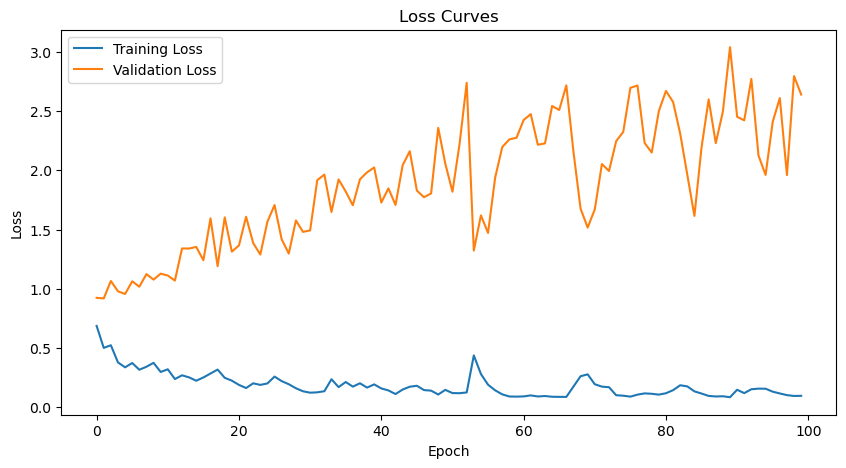

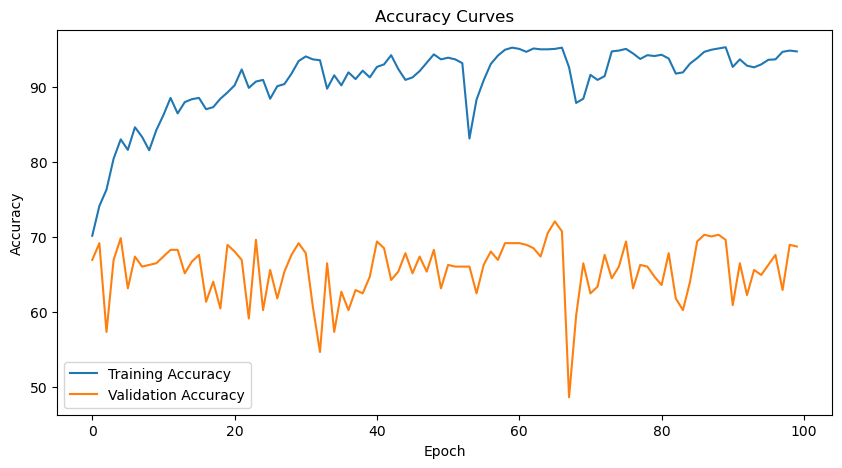

In [14]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

#  model performance on unseen data

In [15]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# Disable gradient computation for testing
with torch.no_grad():
    # Wrap test_loader with tqdm for a progress bar
    test_loop = tqdm(test_loader, desc="Testing")
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        loss = criterion(outputs, labels)

        # Update test loss
        test_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar description with current loss and accuracy
        test_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)

# Compute average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

# Print the results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Testing: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, accuracy=55.1, loss=4.33] 

Test Loss: 3.3694, Test Accuracy: 55.08%


# Plotting the accuracy and the loss of the testing set

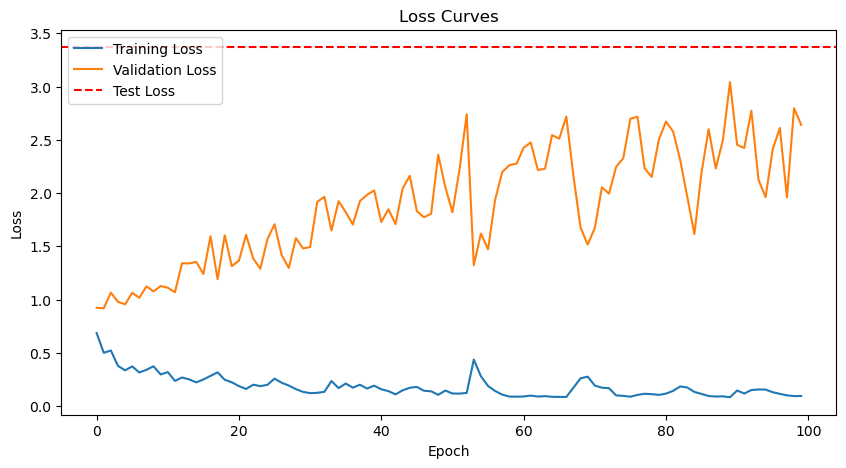

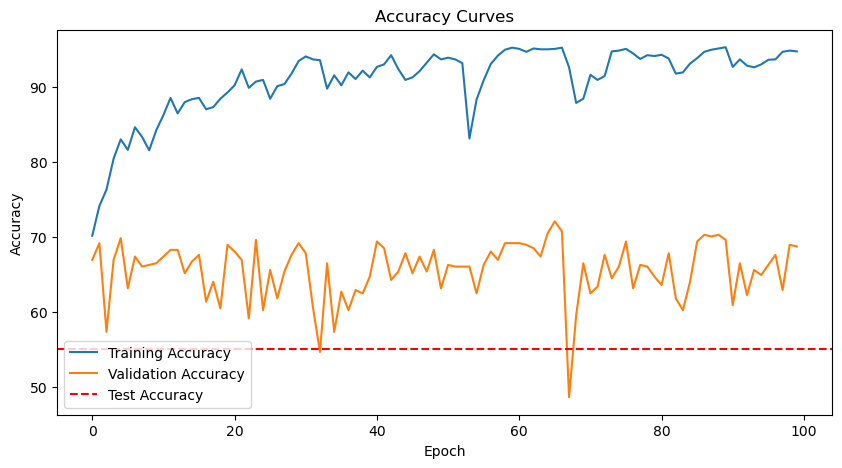

In [16]:
import matplotlib.pyplot as plt

# Plot training, validation, and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Add test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

# Code to Plot Confusion Matrix for Training Set

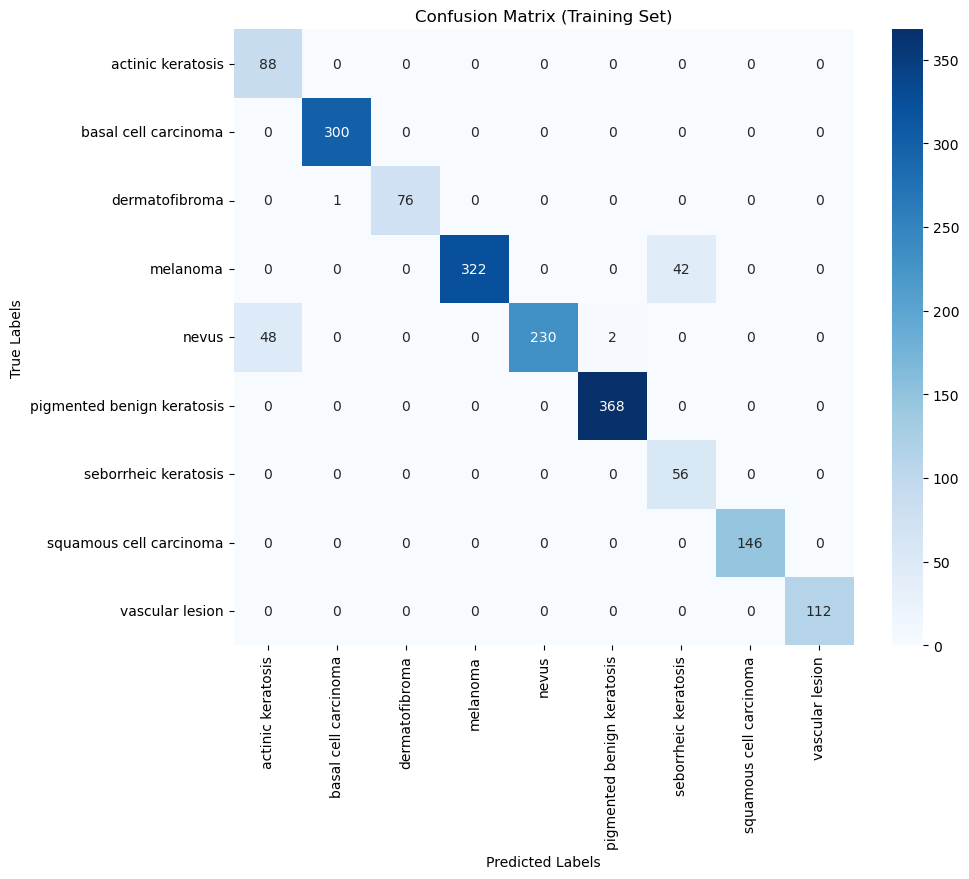

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader instead of test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Training Set)')
plt.show()

# Code to Plot Confusion Matrix for Test Data

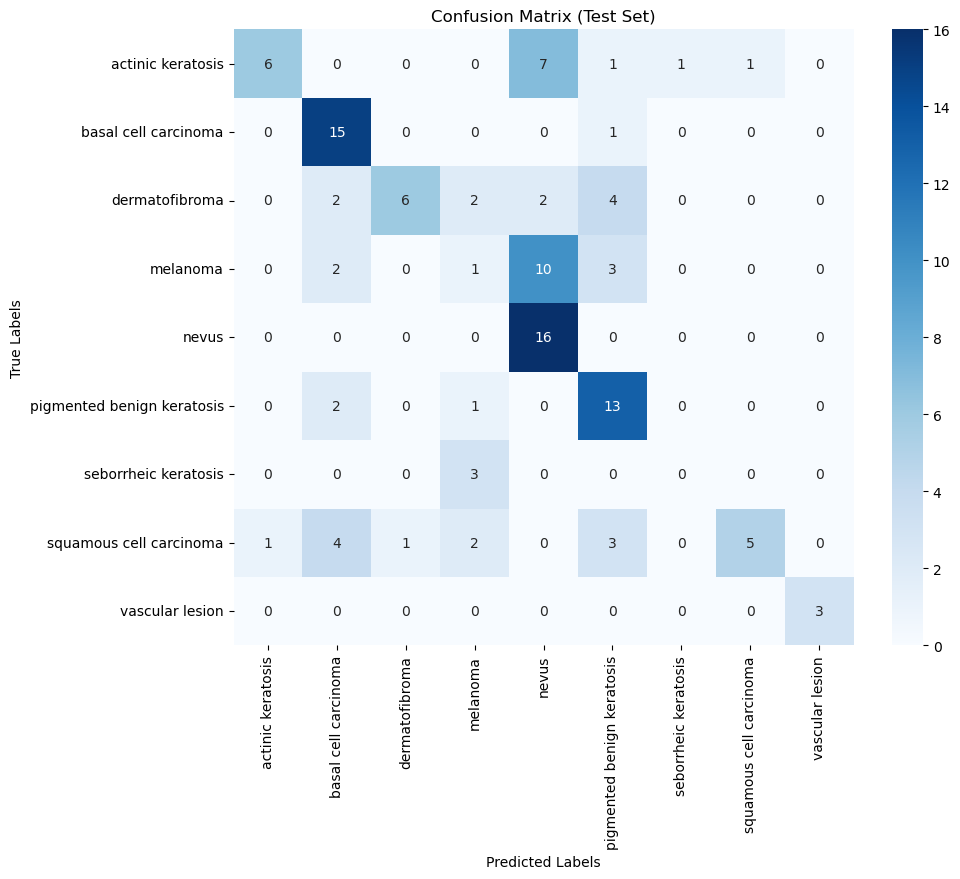

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute the confusion matrix for test data
cm_test = confusion_matrix(all_labels_test, all_preds_test)

# Plot the confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Code to Compute F1 Score, Precision, and Recall for Training Set

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for training data
all_preds_train = []
all_labels_train = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds_train.extend(preds.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

# Compute F1 score, precision, and recall for training set
f1_train = f1_score(all_labels_train, all_preds_train, average='weighted')
precision_train = precision_score(all_labels_train, all_preds_train, average='weighted')
recall_train = recall_score(all_labels_train, all_preds_train, average='weighted')

# Print the results
print(f"Training F1 Score: {f1_train:.4f}")
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")

Training F1 Score: 0.9500
Training Precision: 0.9656
Training Recall: 0.9458


# Code to Compute F1 Score, Precision, and Recall for Test Set

In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits  # Adjust if your model doesn't output .logits
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute F1 score, precision, and recall for test set
f1_test = f1_score(all_labels_test, all_preds_test, average='weighted')
precision_test = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test = recall_score(all_labels_test, all_preds_test, average='weighted')

# Print the results
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")

Test F1 Score: 0.4899
Test Precision: 0.6200
Test Recall: 0.5254
